In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# EDA

## Contexto del dataset

El conjunto de datos provienedel artículo *"JTCAM — Multimaterial structural optimization"*, que extiende la optimización topológica clásica al caso de múltiples materiales. El objetivo principal es maximizar la capacidad de carga o minimizar el volumen bajo una carga fija, manteniendo la convexidad del problema.

El dataset refleja distintas configuraciones experimentales:
- **single_material**: optimización de refuerzo en una sola matriz.
- **bimaterial**: optimización simultánea de dos fases materiales.
- Los parámetros (`ft`, `fc`, `alpha`, `cost`, `volume_fraction`) controlan la relación entre tracción, compresión y restricciones de volumen.
- Las métricas (`pobj`, `p`, `gray_level`) registran la evolución del proceso iterativo de optimización.

Estos experimentos permiten estudiar cómo las condiciones de carga y los parámetros físicos afectan la estructura final y la eficiencia del material.


## ¿Regresión o clasificación?
Este dataset viene de simulaciones de optimización estructural donde la salida es un valor continuo de capacidad estructural, no categorías discretas. Por eso un enfoque de regresión sería mucho más adecuado que uno de clasificación.

Los modelos de clasificación no serían adecuados aquí porque no hay clases, sino un continuo de posibles resultados.

## 1. Importar librerías y configuración inicial

In [11]:
import pandas as pd
import numpy as np
import json
import os
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import zip_longest
from sklearn.preprocessing import LabelEncoder
import ast


sns.set(style="whitegrid", palette="muted", font_scale=1.1)

DATA_PATH = "./drive/MyDrive/Project/data"

## 2. Cargar datos

In [12]:
all_results = []
all_params = []

for exp_name in os.listdir(DATA_PATH):
    exp_path = os.path.join(DATA_PATH, exp_name)
    if not os.path.isdir(exp_path):
        continue

    try:
        with open(os.path.join(exp_path, "results.json")) as f:
            results = json.load(f)

        with open(os.path.join(exp_path, "parameters.json")) as f:
            params = json.load(f)

        lengths = [len(results.get(k, [])) for k in ["pobj", "p", "gray_level"] if k in results]
        n = min(lengths) if lengths else 0
        if n == 0:
            print(f" {exp_name} vacío o con datos inconsistentes")
            continue

        df_r = pd.DataFrame({
            "iteration": range(1, n + 1),
            "pobj": results["pobj"][:n],
            "p": results["p"][:n],
            "gray_level": results["gray_level"][:n],
            "experiment": exp_name
        })

        for k, v in params.items():
            if isinstance(v, (list, dict)):
                df_r[k] = str(v)
            else:
                df_r[k] = v

        all_results.append(df_r)

        df_p = pd.DataFrame([{
            k: str(v) if isinstance(v, (list, dict)) else v
            for k, v in params.items()
        }])
        df_p["experiment"] = exp_name
        all_params.append(df_p)

    except Exception as e:
        print(f" Error procesando {exp_name}: {e}")

df_results = pd.concat(all_results, ignore_index=True)
df_params = pd.concat(all_params, ignore_index=True)

print(f" {len(df_results)} filas en resultados combinados.")
print(f" {len(df_params)} experimentos detectados.")

display(df_results.head())
display(df_params.head())


 209 filas en resultados combinados.
 11 experimentos detectados.


,iteration,pobj,p,gray_level,experiment,problem_type,criterion,rho_interp,rho_min,length_control,volume_fraction,alpha,penalization,pmax,niter_max
0,1,0.339506,1.078318,0.291124,frac_02_bimaterial_fc_1.0_ft_10.0,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
1,2,0.319887,1.159632,0.262781,frac_02_bimaterial_fc_1.0_ft_10.0,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
2,3,0.303453,1.246427,0.257300,frac_02_bimaterial_fc_1.0_ft_10.0,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
3,4,0.290016,1.339617,0.256505,frac_02_bimaterial_fc_1.0_ft_10.0,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
4,5,0.279154,1.440143,0.259190,frac_02_bimaterial_fc_1.0_ft_10.0,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20


,problem_type,criterion,rho_interp,rho_min,length_control,volume_fraction,alpha,penalization,pmax,niter_max,experiment
0,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20,frac_02_bimaterial_fc_1.0_ft_10.0
1,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,2,20,bimaterial_fc_1.0_ft_1.0_cost_0.9
2,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20,frac_02_bimaterial_fc_1.0_ft_1.0
3,LoadMaximization,L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,NaN,True,3,20,frac_02_single_material_fc_1.0_ft_1.0
4,LoadMaximization,L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,NaN,True,3,20,frac_02_single_material_fc_10.0_ft_1.0


Combinar datasets.

In [15]:
all_data = []

for exp_name in os.listdir(DATA_PATH):
    exp_path = os.path.join(DATA_PATH, exp_name)
    if not os.path.isdir(exp_path):
        continue

    try:
        with open(os.path.join(exp_path, "results.json")) as f:
            results = json.load(f)

        with open(os.path.join(exp_path, "parameters.json")) as f:
            params = json.load(f)

        # Determinar longitud mínima
        lengths = [len(results.get(k, [])) for k in ["pobj", "p", "gray_level"] if k in results]
        n = min(lengths) if lengths else 0
        if n == 0:
            print(f" {exp_name} vacío o con datos inconsistentes")
            continue

        # Crear DataFrame base
        df = pd.DataFrame({
            "experiment": exp_name,
            "iteration": range(1, n + 1),
            "pobj": results["pobj"][:n],
            "p": results["p"][:n],
            "gray_level": results["gray_level"][:n],
        })

        # Añadir parámetros a cada fila
        for k, v in params.items():
            if isinstance(v, (list, dict)):
                df[k] = str(v)
            else:
                df[k] = v

        all_data.append(df)

    except Exception as e:
        print(f" Error procesando {exp_name}: {e}")

# Concatenar todos los datos
df_combined = pd.concat(all_data, ignore_index=True)

print(f" DataFrame combinado con {len(df_combined)} filas y {df_combined.shape[1]} columnas.")
display(df_combined)


 DataFrame combinado con 209 filas y 15 columnas.


,experiment,iteration,pobj,p,gray_level,problem_type,criterion,rho_interp,rho_min,length_control,volume_fraction,alpha,penalization,pmax,niter_max
0,frac_02_bimaterial_fc_1.0_ft_10.0,1,0.339506,1.078318,0.291124,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
1,frac_02_bimaterial_fc_1.0_ft_10.0,2,0.319887,1.159632,0.262781,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
2,frac_02_bimaterial_fc_1.0_ft_10.0,3,0.303453,1.246427,0.257300,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
3,frac_02_bimaterial_fc_1.0_ft_10.0,4,0.290016,1.339617,0.256505,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
4,frac_02_bimaterial_fc_1.0_ft_10.0,5,0.279154,1.440143,0.259190,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,3,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204,bimaterial_fc_1.0_ft_1.0_cost_0.25,15,0.102333,2.000000,0.331218,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,2,20
205,bimaterial_fc_1.0_ft_1.0_cost_0.25,16,0.102772,2.000000,0.328415,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,2,20
206,bimaterial_fc_1.0_ft_1.0_cost_0.25,17,0.103224,2.000000,0.325290,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,2,20
207,bimaterial_fc_1.0_ft_1.0_cost_0.25,18,0.103684,2.000000,0.322411,BimaterialLoadMaximization,Composite L1Rankine2D/L1Rankine2D,"['CG', 1]",0.0,0.1,0.2,0.99,True,2,20


Limpieza y preparación de datos.

In [16]:
df = df_combined.copy()

print(f" Dataset cargado: {df.shape[0]} filas, {df.shape[1]} columnas\n")

# Limpiar estructuras anidadas (listas o diccionarios)
def safe_parse(x):
    if isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            return val
        except (ValueError, SyntaxError):
            return x
    return x

df = df.map(safe_parse) if hasattr(df, "map") else df.applymap(safe_parse)

# Detectar columnas con estructuras anidadas
cols_nested = []
for col in df.columns:
    tipos = df[col].apply(lambda x: type(x)).value_counts()
    if any(t in [list, dict] for t in tipos.index):
        cols_nested.append(col)

print(f" Columnas con estructuras anidadas: {cols_nested}\n")

# Aplanar columnas específicas (esta viene como una lista pero en String)
if "rho_interp" in df.columns:
    df["rho_interp_type"] = df["rho_interp"].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)
    df["rho_interp_value"] = df["rho_interp"].apply(lambda x: x[1] if isinstance(x, list) and len(x) > 1 else None)
    df = df.drop(columns=["rho_interp"], errors="ignore")

# Identificar columnas categóricas y numéricas
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
num_cols = df.select_dtypes(include=["number", "bool"]).columns.tolist()

print(" Columnas categóricas iniciales:", cat_cols)
print(" Columnas numéricas iniciales:", num_cols, "\n")

# Convertir categóricas a códigos numéricos
for col in cat_cols:
    if df[col].nunique() <= 20:
        df[col] = df[col].astype("category").cat.codes
    else:
        df[col] = df[col].astype(str)

# Eliminar columnas constantes y/o vacías
constant_cols = [col for col in df.columns if df[col].nunique() <= 1]
empty_cols = [col for col in df.columns if df[col].isna().all()]

df = df.drop(columns=constant_cols + empty_cols, errors="ignore")

print(f" Columnas eliminadas (constantes o vacías): {constant_cols + empty_cols}\n")

# Rellenar nulos
for col in df.columns:
    if df[col].dtype in [np.float64, np.int64]:
        df[col] = df[col].fillna(df[col].median())
    else:
        df[col] = df[col].fillna("Desconocido")

print(" Dataset limpio y listo para modelar:")
print(df.info())
display(df)


 Dataset cargado: 209 filas, 15 columnas

 Columnas con estructuras anidadas: ['rho_interp']

 Columnas categóricas iniciales: ['experiment', 'problem_type', 'criterion', 'rho_interp_type']
 Columnas numéricas iniciales: ['iteration', 'pobj', 'p', 'gray_level', 'rho_min', 'length_control', 'volume_fraction', 'alpha', 'penalization', 'pmax', 'niter_max', 'rho_interp_value'] 

 Columnas eliminadas (constantes o vacías): ['rho_min', 'length_control', 'volume_fraction', 'alpha', 'penalization', 'niter_max', 'rho_interp_type', 'rho_interp_value']

 Dataset limpio y listo para modelar:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 209 entries, 0 to 208
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   experiment    209 non-null    int8   
 1   iteration     209 non-null    int64  
 2   pobj          209 non-null    float64
 3   p             209 non-null    float64
 4   gray_level    209 non-null    float64
 5   pro

,experiment,iteration,pobj,p,gray_level,problem_type,criterion,pmax
0,6,1,0.339506,1.078318,0.291124,0,0,3
1,6,2,0.319887,1.159632,0.262781,0,0,3
2,6,3,0.303453,1.246427,0.257300,0,0,3
3,6,4,0.290016,1.339617,0.256505,0,0,3
4,6,5,0.279154,1.440143,0.259190,0,0,3
...,...,...,...,...,...,...,...,...
204,1,15,0.102333,2.000000,0.331218,0,0,2
205,1,16,0.102772,2.000000,0.328415,0,0,2
206,1,17,0.103224,2.000000,0.325290,0,0,2
207,1,18,0.103684,2.000000,0.322411,0,0,2


## 3. Estadísticas descriptivas básicas

In [17]:
print("Resumen estadístico:")
display(df.describe().T)

print("\nValores nulos por columna:")
print(df.isnull().sum())

print("\nTipos de datos:")
print(df.dtypes)


Resumen estadístico:


,count,mean,std,min,25%,50%,75%,max
experiment,209.0,5.000000,3.169870,0.000000,2.000000,5.000000,8.000000,10.000000
iteration,209.0,10.000000,5.490376,1.000000,5.000000,10.000000,15.000000,19.000000
pobj,209.0,0.160462,0.066036,0.061395,0.108659,0.140216,0.189119,0.343158
p,209.0,1.992384,0.591049,1.078318,1.515751,2.000000,2.262960,3.000000
gray_level,209.0,0.325103,0.041572,0.206748,0.289651,0.328278,0.358212,0.414661
problem_type,209.0,0.272727,0.446431,0.000000,0.000000,0.000000,1.000000,1.000000
criterion,209.0,0.272727,0.446431,0.000000,0.000000,0.000000,1.000000,1.000000
pmax,209.0,2.545455,0.499125,2.000000,2.000000,3.000000,3.000000,3.000000



Valores nulos por columna:
experiment      0
iteration       0
pobj            0
p               0
gray_level      0
problem_type    0
criterion       0
pmax            0
dtype: int64

Tipos de datos:
experiment         int8
iteration         int64
pobj            float64
p               float64
gray_level      float64
problem_type       int8
criterion          int8
pmax              int64
dtype: object


## 4. Distribución de variables clave.

In [18]:
sns.set(style="whitegrid", palette="pastel")
plt.rcParams["figure.figsize"] = (10, 5)

## Configuración y estilo.

### Variables numéricas

 Variables numéricas: ['experiment', 'iteration', 'pobj', 'p', 'gray_level', 'problem_type', 'criterion', 'pmax']



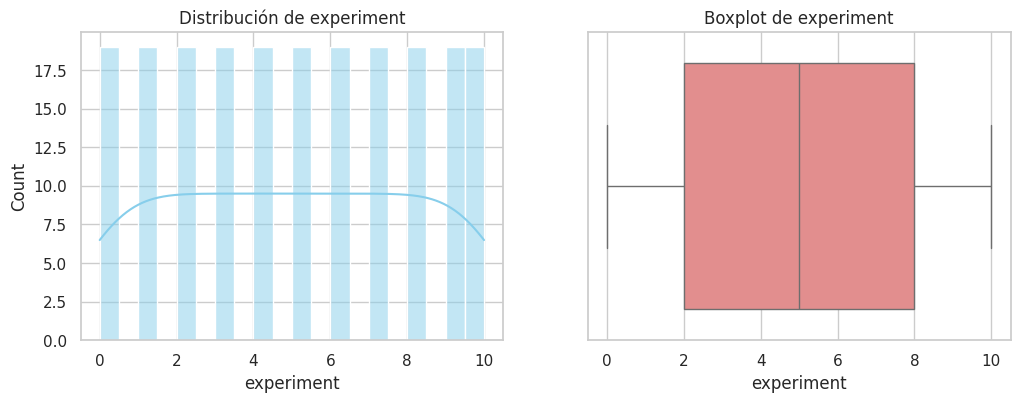

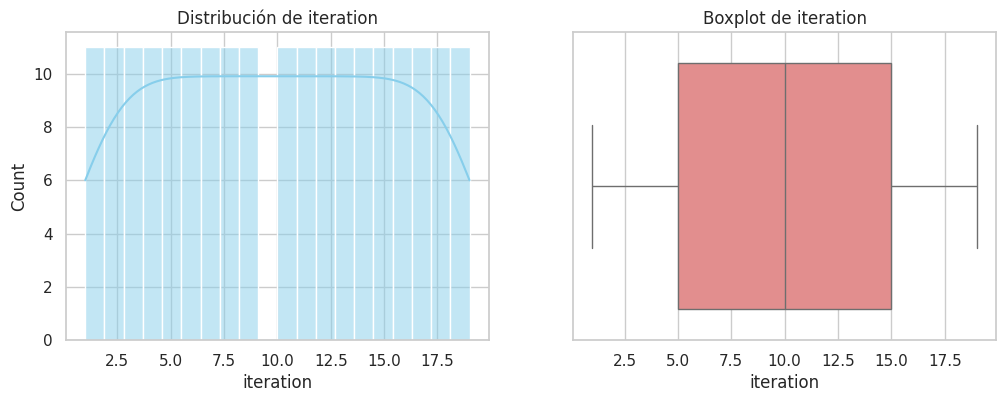

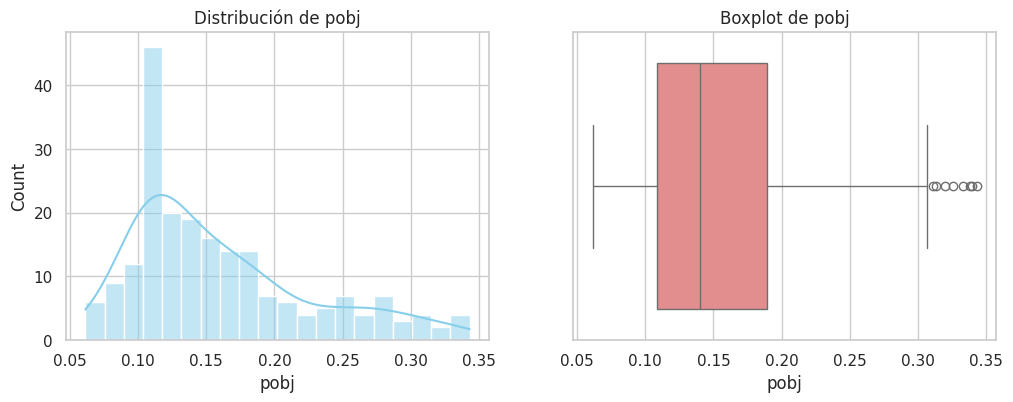

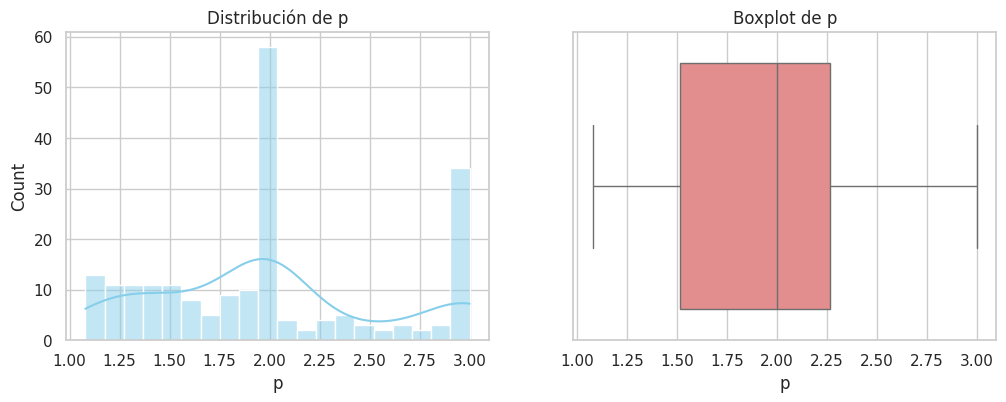

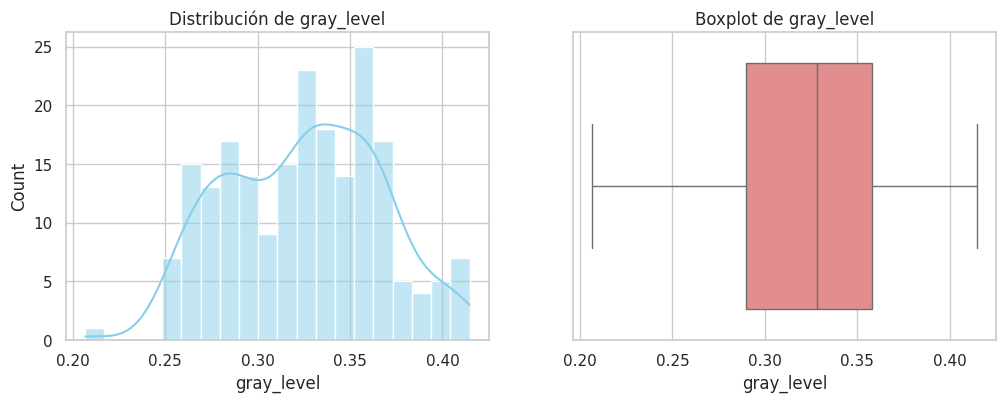

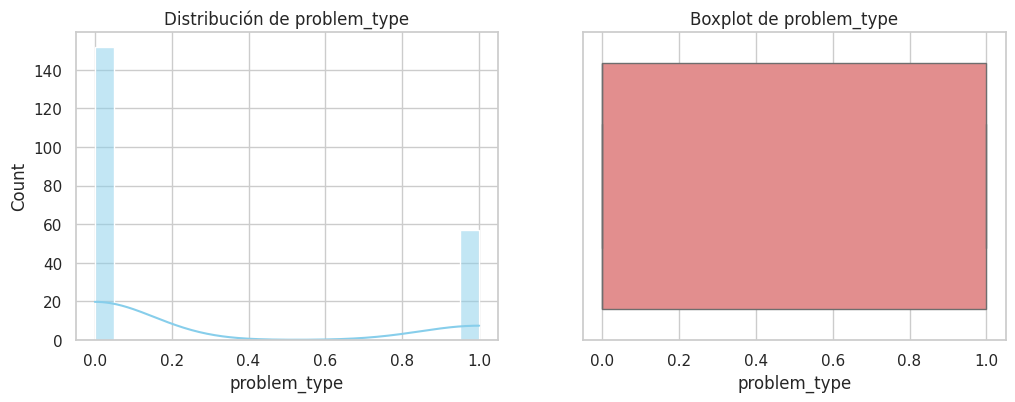

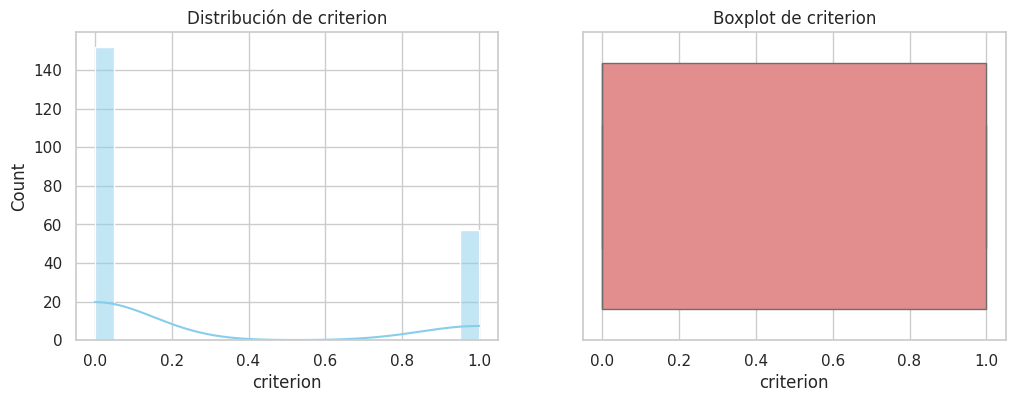

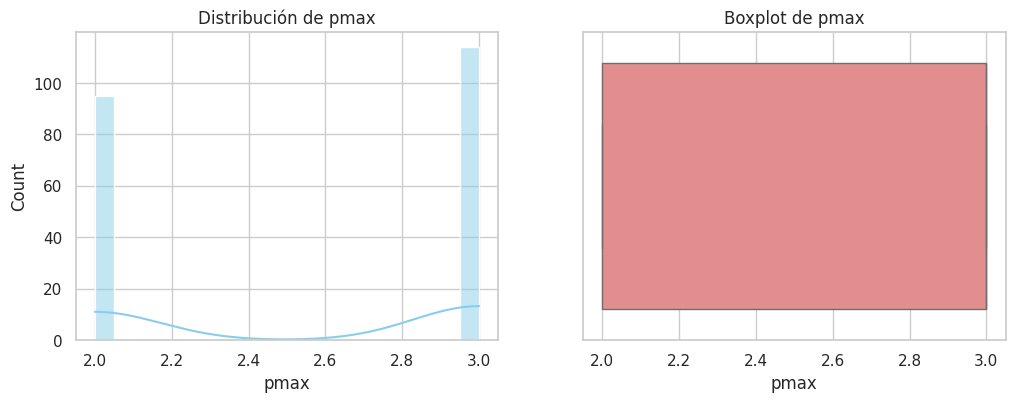

In [20]:
num_cols = df.select_dtypes(include=["number"]).columns.tolist()

if len(num_cols) > 0:
    print(f" Variables numéricas: {num_cols}\n")

    for col in num_cols:
        fig, axes = plt.subplots(1, 2, figsize=(12, 4))
        sns.histplot(df[col], kde=True, bins=20, ax=axes[0], color='skyblue')
        axes[0].set_title(f"Distribución de {col}")
        sns.boxplot(x=df[col], ax=axes[1], color='lightcoral')
        axes[1].set_title(f"Boxplot de {col}")
        plt.savefig(f'drive/MyDrive/Project/results/images/EDA/distribucion_boxplot_{col}.png')
        plt.show()
else:
    print("No se encontraron variables numéricas.\n")

### Variables categóricas

In [21]:
cat_cols = df.select_dtypes(exclude=["number"]).columns.tolist()

if len(cat_cols) > 0:
    print(f" Variables categóricas: {cat_cols}\n")

    for col in cat_cols:
        if df[col].nunique() <= 15:
            plt.figure(figsize=(8, 4))
            sns.countplot(y=df[col], order=df[col].value_counts().index, palette="coolwarm")
            plt.title(f"Distribución de {col}")
            plt.show()
else:
    print("No se encontraron variables categóricas.\n")

No se encontraron variables categóricas.



### Correlación numérica

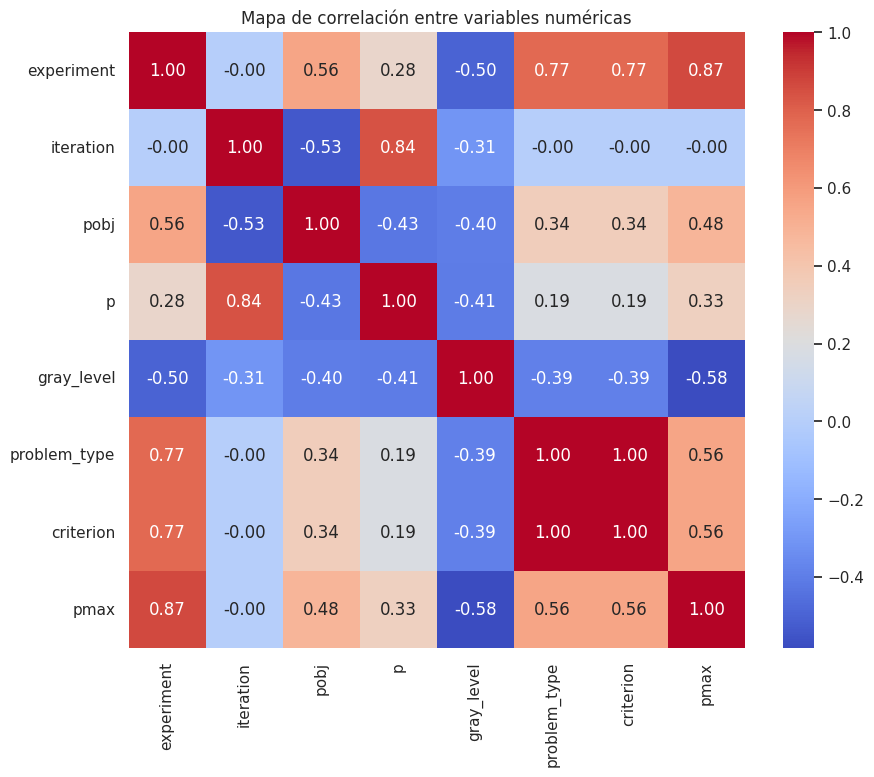

In [22]:
if len(num_cols) > 1:
    plt.figure(figsize=(10, 8))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", square=True)
    plt.title("Mapa de correlación entre variables numéricas")
    plt.savefig('drive/MyDrive/Project/results/images/EDA/mapa_correlacion.png')
    plt.show()

## 5. Guardar resultados (dataframe) del EDA

In [23]:
os.makedirs("drive/MyDrive/Project/results", exist_ok=True)
df.to_csv("drive/MyDrive/Project/results/eda_results.csv", index=False)
print("Archivo guardado en ../results/eda_results.csv")

Archivo guardado en ../results/eda_results.csv


## 6. Riesgos identificados

### Riesgos identificados en el EDA

1. **Correlación alta entre `iteration` y `p`:**  
   `iteration` refleja el avance del proceso de optimización y está fuertemente ligada a `p`.  
   - *Implicación:* posible riesgo de leakage si se incluye directamente en el modelo.

2. **Data drift entre experimentos:**  
   Se observan diferencias notables en las distribuciones de `p` y `pobj` según el `experiment`.  
   - *Implicación:* los modelos podrían no generalizar entre experimentos.

3. **Correlaciones moderadas entre variables:**  
   `p` y `pmax` presentan correlación moderada (≈ 0.33). No es grave, pero podría aportar redundancia leve que conviene revisar en modelos regulares  
   - *Implicación:* conviene evaluar su impacto en el modelo con regularización o selección de features.

4. **Escalado de variables:**  
   Las variables numéricas tienen magnitudes muy distintas (por ejemplo, `iteration` frente a `gray_level`).  
   - *Implicación:* algunos modelos sensibles a escala (KNN, regresión lineal) pueden verse afectados.

5. **Tamaño de muestra limitado (~200 observaciones):**  
   - *Implicación:* posible sobreajuste en modelos complejos o alta varianza en métricas.


### CONCLUSIONES

- El conjunto de datos no tiene outliers importantes.  
- Se encontró que `iteration` está muy relacionada con `p`, lo que puede causar *data leakage*, por eso se excluye del modelo.  
- Las variables tienen diferentes escalas, por lo que se aplicará un escalado en el preprocesamiento.  
- Se observan algunas diferencias entre experimentos (posible *data drift*).  
- En general, los datos están en buen estado para construir un modelo baseline simple.
